In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, QuantumCircuit
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.circuit import Parameter
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [48]:
df = pd.read_csv('Datasets/Mentor/mock_train_set.csv')
df.head(8)

,0,1,2,3,x
0,2789.26,1000,10,20,0
1,4040.01,1000000,1,1,1
2,2931.20,10000,10000,40,1
3,3896.54,10000,100000,30,1
4,982.06,100,1000,75,0
5,1579.81,1,1000,90,0
6,3031.77,1000000,1000000,35,1
7,860.44,10,100000,60,0


In [49]:
df_test = pd.read_csv('Datasets/Mentor/mock_test_set.csv')
df_test.head(8)

,0,1,2,3,x
0,2988.55,10000,10000,75,1
1,3413.80,1,100,90,0
2,3891.52,1,1,5,0
3,4514.99,10000,1000000,25,1
4,752.29,10,10,90,0
5,1404.13,10000,1000,5,1
6,3390.65,1000000,10000,5,1
7,2620.98,1,10,75,0


In [50]:
f_name_list = list(df)
list(f_name_list)

['0', '1', '2', '3', 'x']

In [51]:
print('Number of empty data in the set: '), df.isnull().sum().sum()
clean_data = df.dropna()

Number of empty data in the set: 


In [52]:
x_org = clean_data.drop('x', axis=1)
cat = clean_data.x

rel = ExtraTreesClassifier()
rel.fit(x_org, cat)

ExtraTreesClassifier()

In [53]:
print(rel.feature_importances_)

[0.13878188 0.48860204 0.27347564 0.09914044]


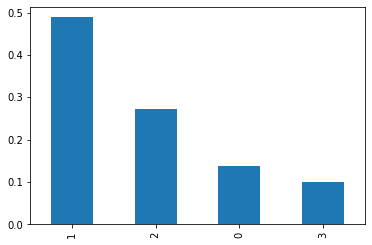

In [54]:
rank_f = pd.Series(rel.feature_importances_, index=x_org.columns)
rank_f.nlargest(20).plot(kind='bar')
plt.show()

In [55]:
corr = clean_data.iloc[:,:-1].corr()
classified = mutual_info_classif(x_org, cat)
class_data = pd.Series(classified, index=x_org.columns)
ordered_f = class_data.sort_values(ascending=False)

In [56]:
ordered_f.head(10)

1    0.313390
2    0.293678
0    0.060894
3    0.000000
dtype: float64

In [57]:
test_ratio = 0.2
seed = 1984
selected_f = clean_data[['0','1','2','3','x']]
selected_test = df_test[['0','1','2','3','x']]

x_train = np.array(selected_f.drop('x', axis =1))
y_train = np.array(selected_f.x)
x = preprocessing.normalize(x_train, axis=0)

x_test = np.array(selected_test.drop('x', axis =1))
y_test = np.array(selected_test.x)
x = preprocessing.normalize(x_test, axis=0)

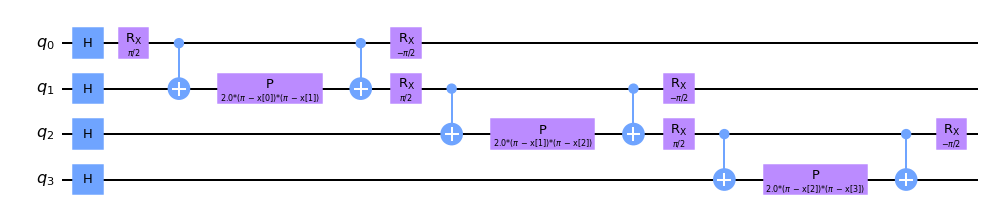

In [58]:
feature_dim = x.shape[1]
emb_layer = 1
ent = 'linear'

fmap = PauliFeatureMap(feature_dimension=feature_dim, reps=emb_layer, entanglement=ent, paulis=['ZY'])
fmap.decompose().draw('mpl', scale=1)

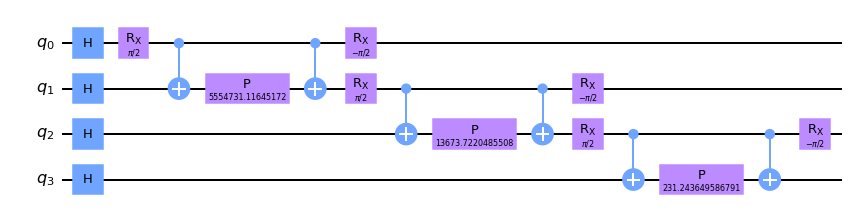

In [59]:
fmap.assign_parameters({k:v for (k,v) in zip(fmap.parameters, x_train[0])}).decompose().draw('mpl', scale=1)

In [60]:
def ansatz_circ(feature_dim, layer, weights):
    ansatz = QuantumCircuit(feature_dim)
    for layer in range(layer):
        for i in range(feature_dim):
            ansatz.ry(weights[i], i)
            #ansatz.rz(weights[i+4], i)
        for i in range(feature_dim - 1):
            ansatz.cx(i, i+1)
        ansatz.cx(3,0)
        ansatz.barrier()
    return ansatz

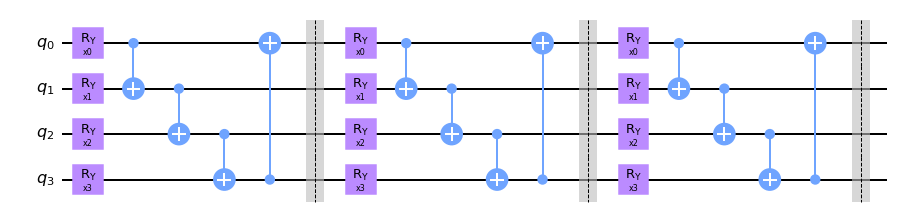

In [61]:
layer = 3
np.random.seed(seed)
nb_w = 4
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

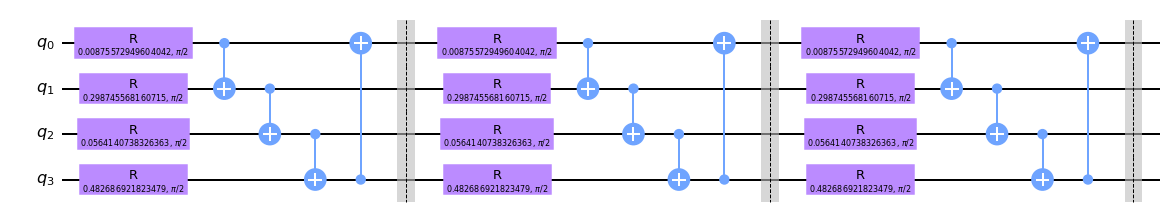

In [62]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

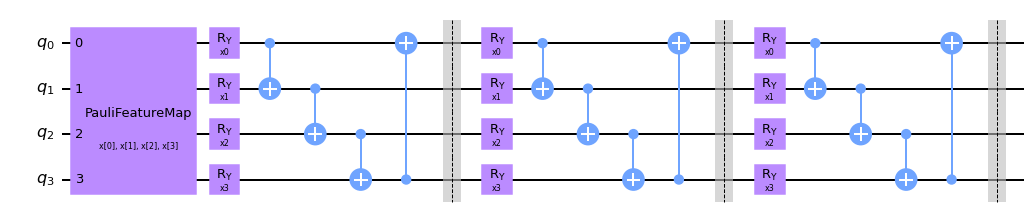

In [63]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [64]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [65]:
qasm_sim = Aer.get_backend('aer_simulator')
qinst = QuantumInstance(qasm_sim, 2048, seed_simulator=seed)

In [66]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [67]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.56396484, 0.43603516]])

In [68]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.33496094,  0.07128906,  0.0871582 ,  0.24145508],
        [ 0.33496094, -0.07128906, -0.0871582 , -0.24145508]]])

In [69]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [70]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [71]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 374.01211901931555
6 - 374.39679141212486
9 - 336.2535267825288
12 - 316.292550074642
15 - 315.71977910659956
18 - 316.83409033929127
21 - 309.27380819755007
24 - 310.89809074136167
27 - 299.9273753869494
30 - 298.62830508606874
33 - 298.44016531812247
36 - 296.89334436113575
39 - 296.2391151544572
42 - 295.16239423532386
45 - 294.9404164857268
48 - 293.23677740442156
51 - 291.37874891484455
54 - 287.66303355858264
57 - 288.152135952202
60 - 283.1440916026579
63 - 283.0234564552869
66 - 282.9108846610463
69 - 282.91708377530705
72 - 282.46628270961054
75 - 282.70922354481434
78 - 281.6427903312416
81 - 281.28115779943596
84 - 281.0269821799533
87 - 280.8358572276828
90 - 280.44520521545394
93 - 280.7302067691843
96 - 280.8190218288231
99 - 280.68569007357627
102 - 280.49791016522164
105 - 280.30136458351774
108 - 280.41087839167426
111 - 280.1293555942607
114 - 280.55229734383056
117 - 280.3599696713046
120 - 280.35506526321365
123 - 280.38888991666397
126 - 280.4041782063938
129 -

In [72]:
score_train_1 = vqc.score(x_train, y_train_1h)
score_test_1 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_1}')
print(f'Score on the test set {score_test_1}')

Score on the train set 0.6933333333333334
Score on the test set 0.6083333333333333


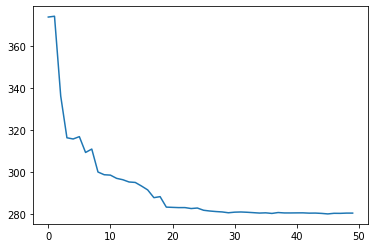

In [73]:
plt.plot(loss_recorder)

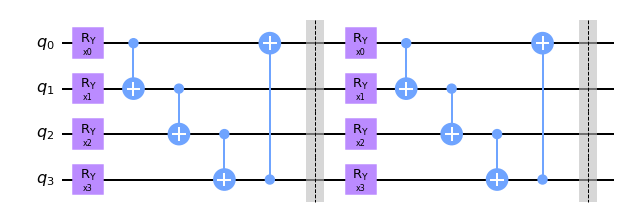

In [74]:
layer = 2
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

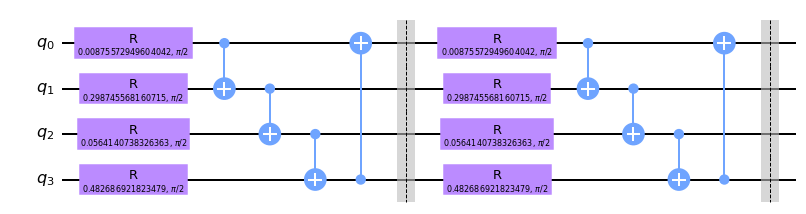

In [75]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

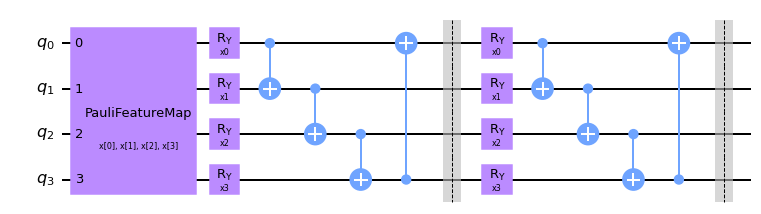

In [76]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [77]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [78]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.484375, 0.515625]])

In [79]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.09912109,  0.14501953, -0.3371582 , -0.15698242],
        [ 0.09912109, -0.14501953,  0.3371582 ,  0.15698242]]])

In [80]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 311.748548985698
6 - 307.1620264147623
9 - 302.61374929170006
12 - 301.0322468909314
15 - 300.4808035557865
18 - 299.8503942549769
21 - 299.6585353985014
24 - 299.548573247502
27 - 299.5663054704704
30 - 299.5118563232454
33 - 299.5869261846048
36 - 299.21950426612995
39 - 298.9427267390304
42 - 298.18951462837526
45 - 297.83108958112615
48 - 297.8122729992001
51 - 297.81970680409154
54 - 297.5819569980011
57 - 297.73479146405987
60 - 297.4590882020432
63 - 297.3461403173046
66 - 297.25405147187155
69 - 296.9295698379829
72 - 297.0590565176971
75 - 297.15092371224125
78 - 297.050517084689
81 - 296.73228418444336
84 - 296.5508417897804
87 - 296.667522774624
90 - 296.68587117869686
93 - 296.6985005990364
96 - 296.80184689521514
99 - 296.8189829888834
102 - 296.6221346480551
105 - 296.370751617907
108 - 296.3212171803188
111 - 296.1457282919623
114 - 296.2649288077798
117 - 296.1026821636756
120 - 296.1249004396007
123 - 296.1337957433916
126 - 295.94661051335964
129 - 296.01460056042

In [81]:
score_train_2 = vqc.score(x_train, y_train_1h)
score_test_2 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_2}')
print(f'Score on the test set {score_test_2}')

Score on the train set 0.5566666666666666
Score on the test set 0.5416666666666666


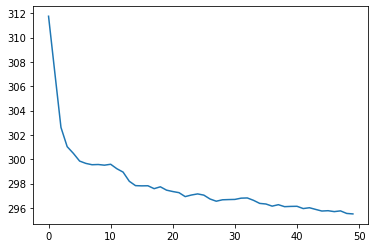

In [82]:
plt.plot(loss_recorder)

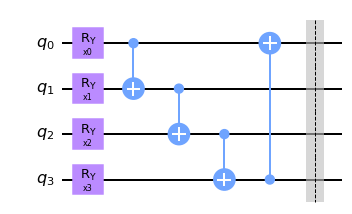

In [83]:
layer = 1
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

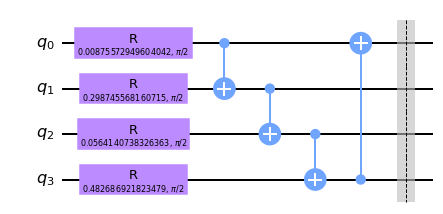

In [84]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

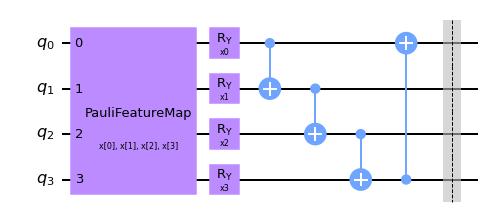

In [85]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [86]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [87]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.56347656, 0.43652344]])

In [88]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.01416016, -0.41015625, -0.40698242,  0.41748047],
        [ 0.01416016,  0.41015625,  0.40698242, -0.41748047]]])

In [89]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 315.55038115739904
6 - 314.52820987079554
9 - 312.7378779303265
12 - 311.2994548269261
15 - 308.9213961504181
18 - 308.9326115516212
21 - 308.61138050502734
24 - 299.51211162590755
27 - 299.521471041827
30 - 298.54140990706605
33 - 297.1021690840554
36 - 296.8892471828106
39 - 296.73650741588074
42 - 296.6741819784844
45 - 296.3141498518843
48 - 295.93264220133796
51 - 295.72864564292036
54 - 296.36322902150135
57 - 296.1784957997206
60 - 296.1113503282046
63 - 296.16603947179385
66 - 296.10055221384994
69 - 296.14001620692966
72 - 296.2474449297602
75 - 296.3514587217592
78 - 296.10763230709586
81 - 296.1467751994381
84 - 296.1259156587646
87 - 296.0335727837406
90 - 296.0352282720734
93 - 296.255377614083
96 - 296.175161525564
99 - 296.25930970284776
102 - 296.26487857410814
105 - 296.19065124383866
108 - 296.22044413102697
111 - 296.1364020994461
114 - 296.0787711761261
117 - 296.1317242101957
120 - 296.25320089665735
123 - 296.01681986527785
126 - 296.05843073608827
129 - 296.1

In [90]:
score_train_3 = vqc.score(x_train, y_train_1h)
score_test_3 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_3}')
print(f'Score on the test set {score_test_3}')

Score on the train set 0.5566666666666666
Score on the test set 0.475


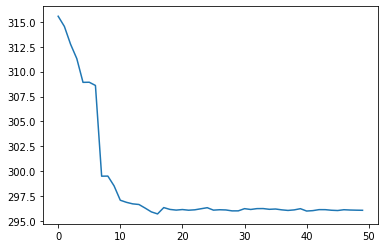

In [91]:
plt.plot(loss_recorder)